# Syncing spike data with pycontrol

In [7]:
%reload_ext autoreload
%autoreload 2

import spikeinterface.full as si

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import matplotlib.pylab as plt 
from tqdm.auto import tqdm
from trialexp.process.pyphotometry.utils import *
from trialexp.utils.ephys_utilities import create_sync_photo_ephys
import pandas as pd 
import xarray as xr
from trialexp.process.pycontrol import event_filters
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [116]:
sel_probe = 'ProbeB'

In [117]:
base = Path('/home/MRC.OX.AC.UK/ndcn1330/ettin')
path = base / Path('Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-23-191740/ephys/sorting')

In [135]:
figure_output = base/Path('Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-23-191740/processed/figures/ephys')
figure_output

PosixPath('/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-23-191740/processed/figures/ephys')

In [119]:
# Manualliy find the correct timestamp file for now
rec_properties = pd.read_csv(path.parent/'rec_properties.csv')
rec_properties.sync_path.iloc[2]

# Manually get the start time for now
# TODO: fix the bug in create_folder
tstart = rec_properties.tstart.iloc[0]
tstart

626.1124

## Attempt to load the channel position from raw kilosort output


In [120]:
koutput_folder = path/'output'/sel_probe

In [121]:
templates = np.load(koutput_folder/'templates.npy')
templates.shape

(915, 82, 384)

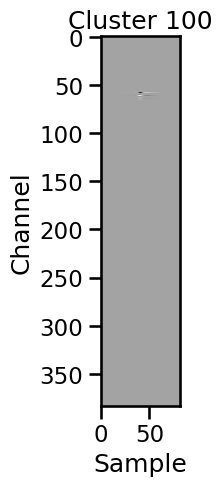

In [122]:
cluster_id = 100
plt.imshow(templates[cluster_id,:,:].T, cmap='gray');
plt.ylabel('Channel')
plt.xlabel('Sample')
plt.title(f'Cluster {cluster_id}');

In [123]:
peak_amp = np.max(abs(templates), axis=1)
channel_idx = np.argmax(peak_amp, axis=1)

# Data sync

In [124]:
#load and create the sync object
# sync to photometry data for now, but later probably should sync everything back to pycontrol

photo_file = list((path.parents[1]/'pyphotometry').glob('*.ppd'))[0]
photo_data = import_ppd(photo_file)
photo_time = photo_data['pulse_times_2']
rsync = create_sync_photo_ephys(photo_time, path.parent/'correct')
assert rsync is not None

In [125]:
#load the spike extractor
probe_sorting = si.load_extractor(path/sel_probe)

In [126]:
# rearrange the unit id such that they are in the same order as depth
unit_ids = probe_sorting.get_unit_ids()
idx = np.argsort(channel_idx)
unit_ids_sorted = unit_ids[idx]

In [153]:
# Sync and  all the sorting to ms
# spike time from kilosort count from the beginning of the recording
# where the rsync time count from the beginning of the open ephys session
# so we need to shift the spike time to the ephys rsync time unit first

def get_sorting_spiketime(sorting,rsync,tstart, Fs=30000):
    spike_times = []
    max_time = 0
    for id in tqdm(unit_ids_sorted):
        ks_label = probe_sorting.get_unit_property(id, 'KSLabel') # for future
        spk_time = probe_sorting.get_unit_spike_train(id)
        spk_time = (spk_time/Fs+tstart)*1000 #need to shift by the starting time of recording
        spk_time = rsync.A_to_B(spk_time)

        if len(spk_time)>0:
            max_time = max(max_time, spk_time[-1])
        spike_times.append(spk_time)
    return spike_times

spike_times = get_sorting_spiketime(probe_sorting, rsync, tstart)
print(len(spike_times))

  0%|          | 0/915 [00:00<?, ?it/s]

915


In [154]:
# load xarray data and use that to bin the firing rate
xr_session = xr.load_dataset(path.parents[1]/'processed'/'xr_session.nc')

In [155]:
# convert spike timing to firing rate
def calculate_spike_rate(spike_times, bins, bin_size):
    spike_rates = np.zeros((len(bins)-1, len(spike_times)))
    for i in tqdm(range(len(spike_times))):
        count, _ = np.histogram(spike_times[i], bins) 
        spike_rates[:,i] = count * (1000/bin_size)
    return spike_rates

bin_size = 50
bins = np.append(xr_session.time.data, xr_session.time.data[-1]+50) # make sure we cover the whole range

spike_rates = calculate_spike_rate(spike_times, bins, bin_size)


  0%|          | 0/915 [00:00<?, ?it/s]

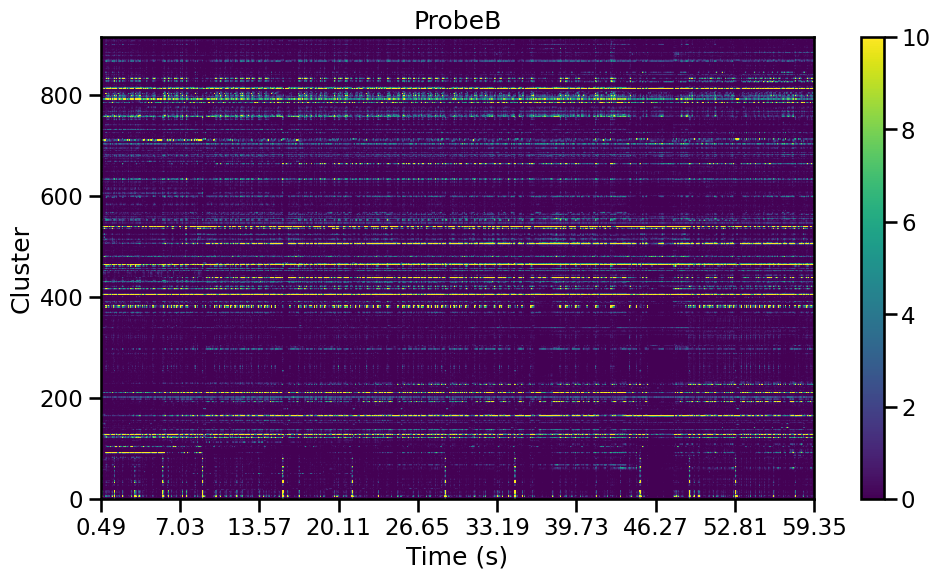

In [158]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
plt.imshow(spike_rates.T, vmax=10)
plt.colorbar()
ax.set_aspect(50)
xticks = np.linspace(0,spike_rates.shape[0],10).astype(int)
ax.set_xticks(xticks);
labels = [f'{x:.2f}' for x in bins[xticks]/1000/60]
ax.set_xticklabels(labels);
ax.set_ylabel('Cluster');
ax.set_xlabel('Time (s)')
ax.invert_yaxis()
ax.set_title(sel_probe)
plt.savefig(figure_output/f'{sel_probe}_time_all.png', dpi=300)

In [161]:
cluster_ids = probe_sorting.get_unit_ids()
xa_spike_rate = xr.DataArray(
    spike_rates, coords={'time':bins[:-1], 
                         'cluster_id':cluster_ids},
    dims=('time','cluster_id'))

xr_session['spike_rate'] = xa_spike_rate

## Align spike data to events

In [162]:
df_pycontrol = pd.read_pickle(path.parents[1]/'processed'/'df_pycontrol.pkl')
rsync_time = df_pycontrol[df_pycontrol.name=='rsync'].time
pyphoto_aligner = Rsync_aligner(pulse_times_A= rsync_time, 
                pulse_times_B= photo_time, plot=False) #align pycontrol time to pyphotometry time


In [163]:
df_event = pd.read_pickle(path.parents[1]/'processed'/'df_events_cond.pkl')
trial_window = df_event.attrs['trial_window']
dataset = xr_session.copy()

In [164]:
trigger = df_event.attrs['triggers'][0]
event_time_coord = dataset.event_time
sampling_rate = dataset.attrs['sampling_rate']/bin_size #the data has already been downsampled
add_event_data(df_event, event_filters.get_first_event_from_name,
               trial_window, pyphoto_aligner, dataset, event_time_coord, 
               'spike_rate', trigger, sampling_rate,
               filter_func_kwargs={'evt_name':trigger}, 
               time_tolerance=bin_size, 
               extra_dimen=['cluster_id'], extra_coord={'cluster_id':cluster_ids})

(161, 120, 915)


In [165]:
add_event_data(df_event, event_filters.get_first_bar_off, trial_window,
               pyphoto_aligner, dataset, event_time_coord, 
               'spike_rate', 'first_bar_off', sampling_rate, 
              time_tolerance=bin_size, filter_func_kwargs={},
               extra_dimen=['cluster_id'], extra_coord={'cluster_id':cluster_ids})

(161, 120, 915)


In [166]:
add_event_data(df_event, event_filters.get_first_spout, trial_window,
               pyphoto_aligner, dataset, event_time_coord, 
               'spike_rate', 'first_spout', sampling_rate, 
              time_tolerance=bin_size, filter_func_kwargs={},
               extra_dimen=['cluster_id'], extra_coord={'cluster_id':cluster_ids})

(161, 120, 915)


In [167]:
dataset.to_netcdf(path.parents[1]/'processed'/f'xr_spikes_{sel_probe}.nc', engine='h5netcdf')

In [199]:
def align_peak(x):
    # Align the data according to peak location
    x = np.nanmean(dataset['first_spout_spike_rate'].data,axis=0)
    maxidx = np.argmax(x,axis=0)
    idx = np.argsort(maxidx)
    
    return x[:,idx], idx

def plot_rate_map(rates, xlabels, vline_x, nxsticks=10):
    # rate is assumed to be a 2D array in the shape (time x channel)
    fig,ax = plt.subplots(1,1,figsize=(12,8))
    plt.imshow(rates.T, vmax=10)
    plt.colorbar()
    ax.set_aspect(0.1)
    
    # figure out the correct tick label
    
    xticks = np.linspace(0,rates.shape[0]-1,nxsticks).astype(int)
    ax.set_xticks(xticks);
    labls = np.array([f'{x:.2f}' for x in xlabels])
    ax.set_xticklabels(labls[xticks]);
    ax.invert_yaxis()
    ax.set(xlabel='Time (s)', ylabel='Cluster')

    # find the cloest match 0 point
    zero_pt = np.argmin(abs(vline_x-xlabels))
    ax.axvline(zero_pt,color='w')
    return fig, ax

xlabels = np.round(dataset.event_time.data/50)*50/1000 #round to the nearest 10ms

## Single trial data

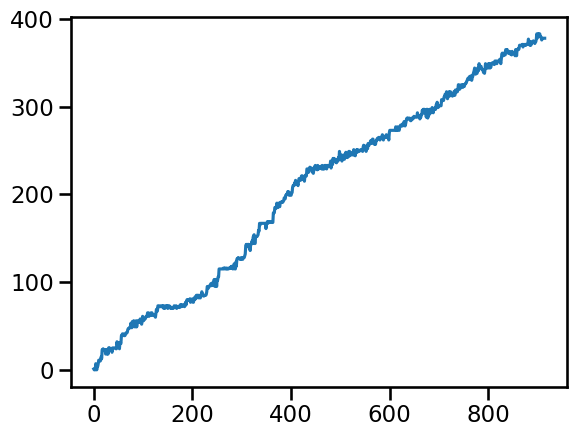

In [210]:
plt.plot(channel_idx)

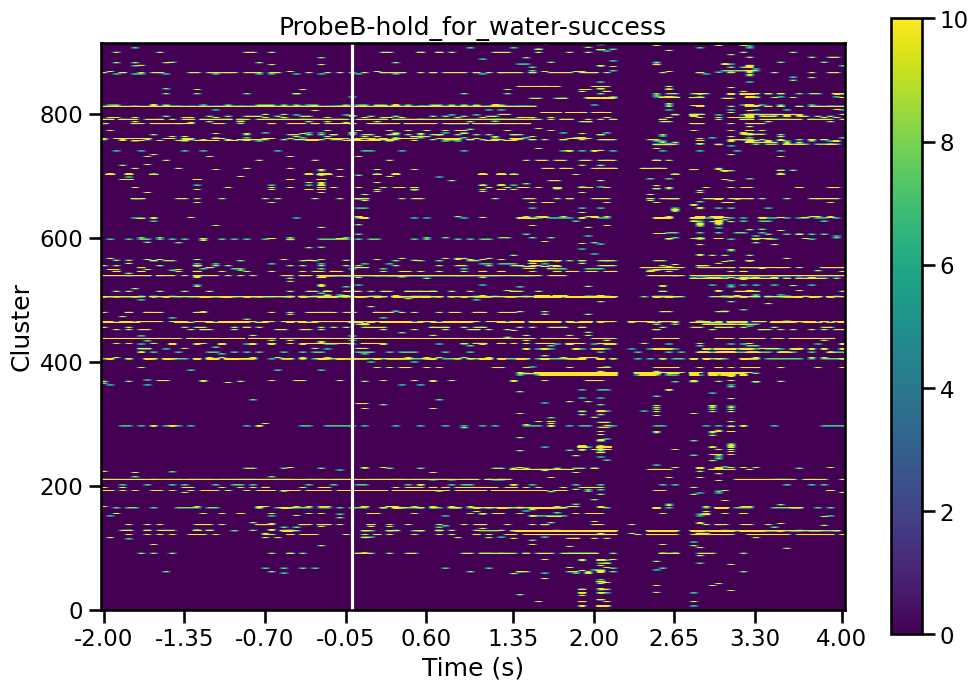

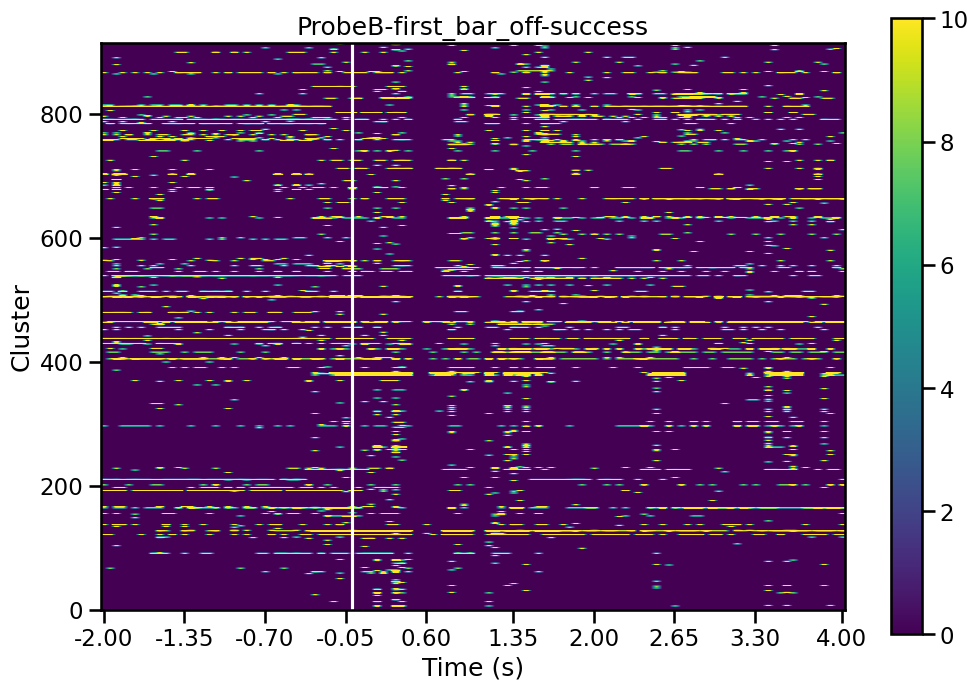

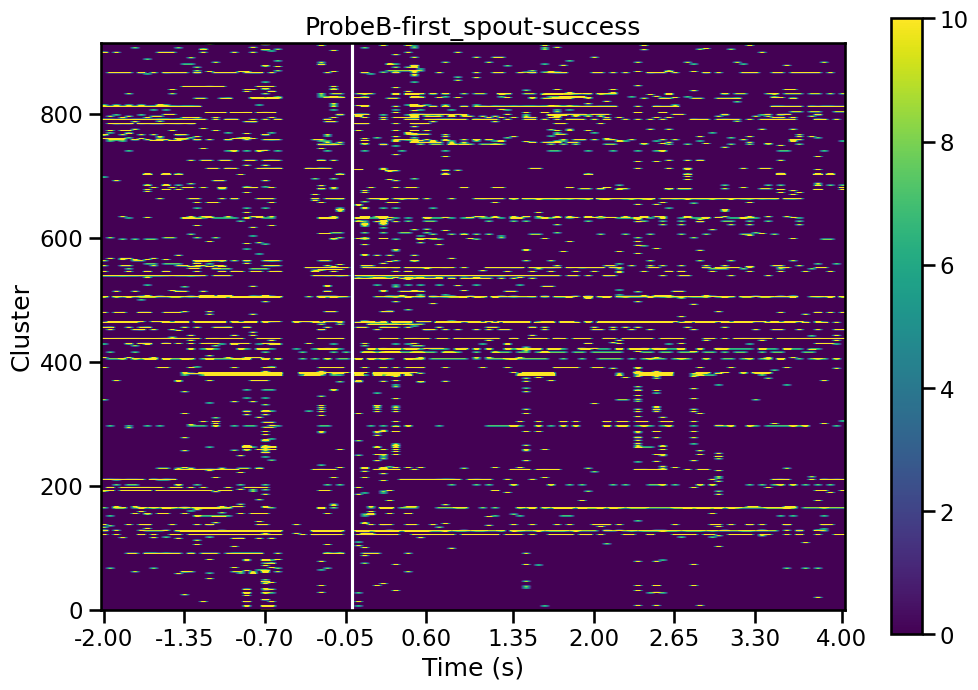

In [218]:
var2plot = ['hold_for_water', 'first_bar_off', 'first_spout']
trial_no = 70
is_save = False
for v in var2plot:
    fig, ax = plot_rate_map(dataset[v+'_spike_rate'].data[trial_no,:,:], xlabels,  0)
    success = dataset.success[0,trial_no]
    if success:
        success_text = 'success'
    else:
        success_text = 'failed'
        
    ax.set_title(sel_probe+f'-{v}-{success_text}')
    if is_save:
        fig.savefig(figure_output/f'{sel_probe}_{v}_trial_{trial_no}.png', dpi=300)

### Average data

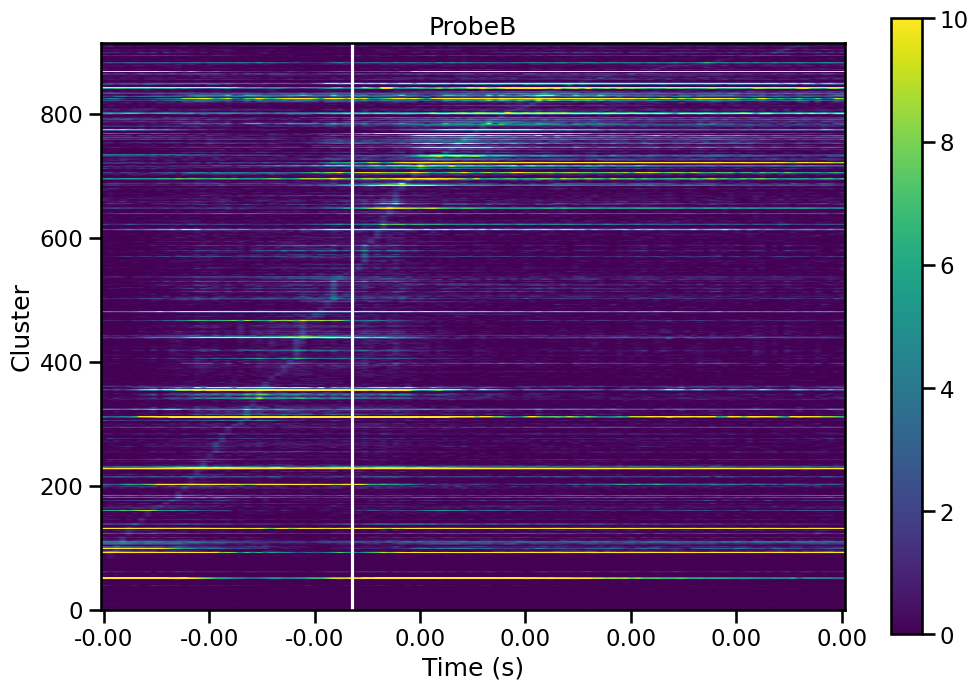

In [208]:
xsorted,chan_sort_idx = align_peak(x)
x = np.nanmean(dataset['hold_for_water_spike_rate'].data,axis=0)
fig, ax = plot_rate_map(xsorted, xlabels/1000, 0,nxsticks=8)
ax.set_title(sel_probe)
# fig.savefig(figure_output/f'{sel_probe}_holder_for_water.png', dpi=300)

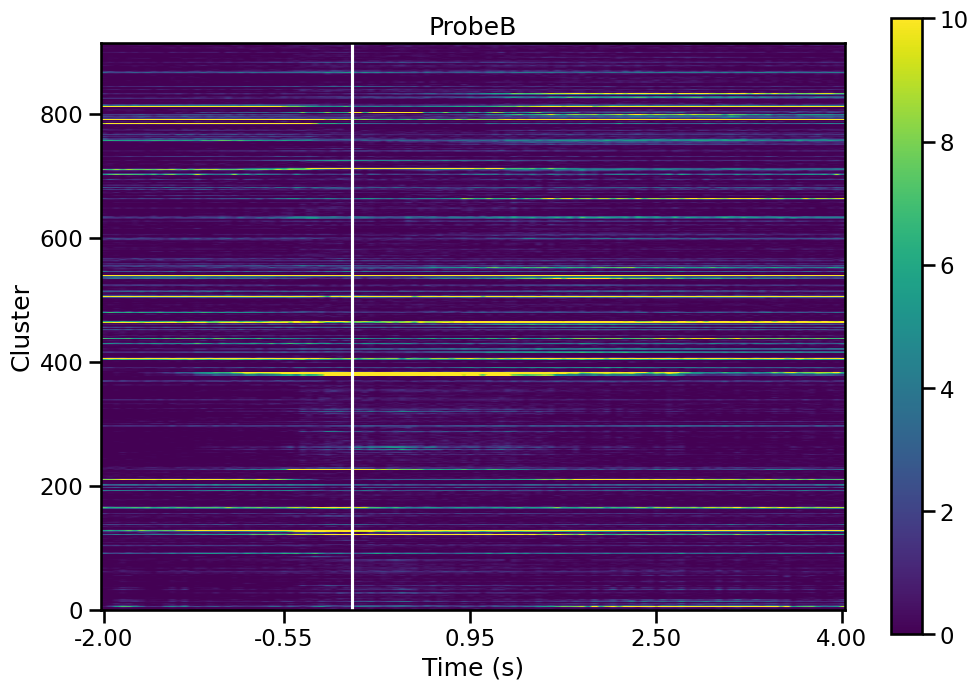

In [188]:
x = np.nanmean(dataset['first_spout_spike_rate'].data,axis=0)
fig, ax = plot_rate_map(x, xlabels/1000, 0,nxsticks=5)
ax.set_title(sel_probe)
fig.savefig(figure_output/f'{sel_probe}_first_spout.png', dpi=300)

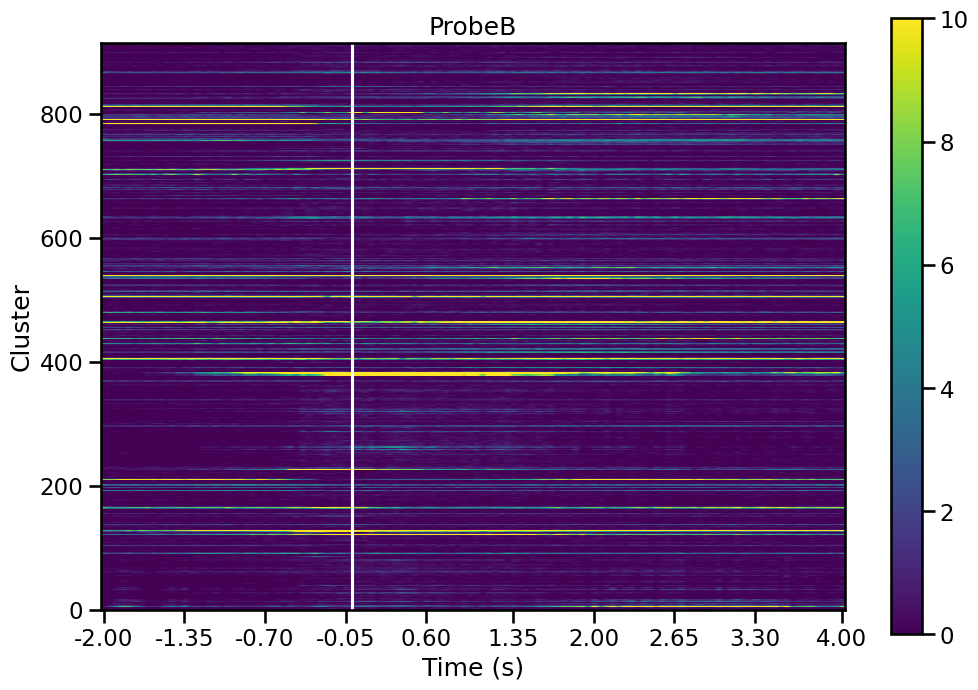

In [192]:
x = np.nanmean(dataset['first_bar_off_spike_rate'].data,axis=0)
fig, ax = plot_rate_map(x, xlabels/1000, 0)
ax.set_title(sel_probe)
fig.savefig(figure_output/f'{sel_probe}_first_bar_off.png', dpi=300)

<Axes: xlabel='event_time', ylabel='hold_for_water_analog_1_df_over_f'>

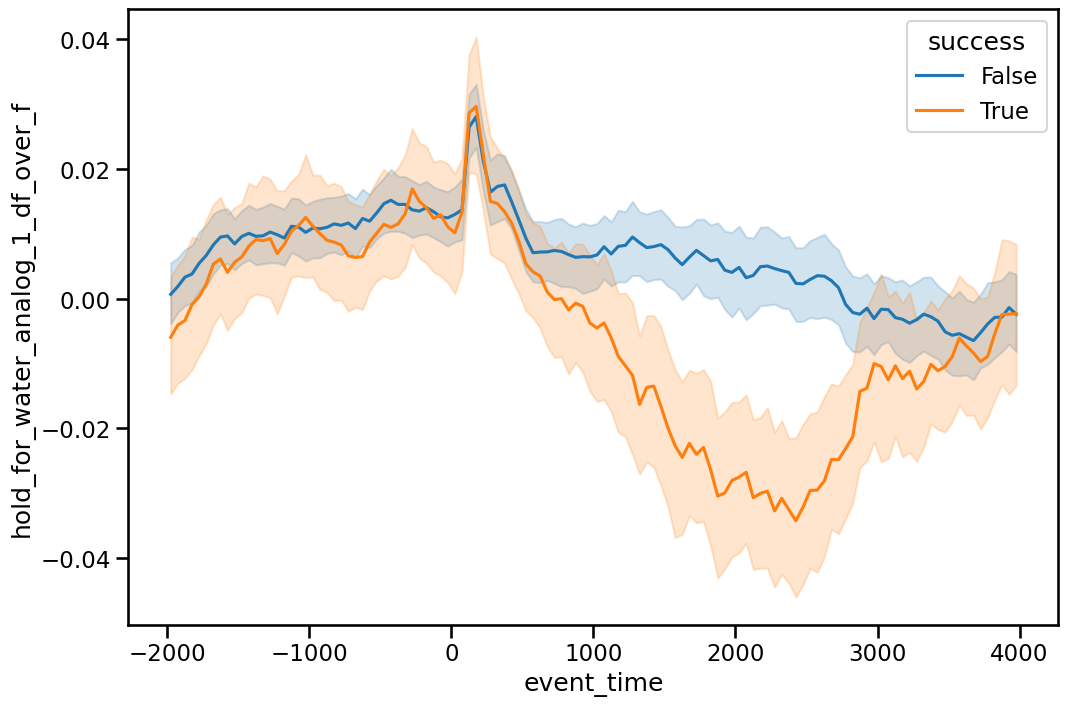

In [57]:
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize=(12,8))

df2plot = dataset[['hold_for_water_analog_1_df_over_f','success']].to_dataframe().reset_index()

sns.lineplot(x = 'event_time', y='hold_for_water_analog_1_df_over_f', hue='success', data=df2plot, ax=ax)
fig.savefig(figure_output/'photometry